## Environment Settings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


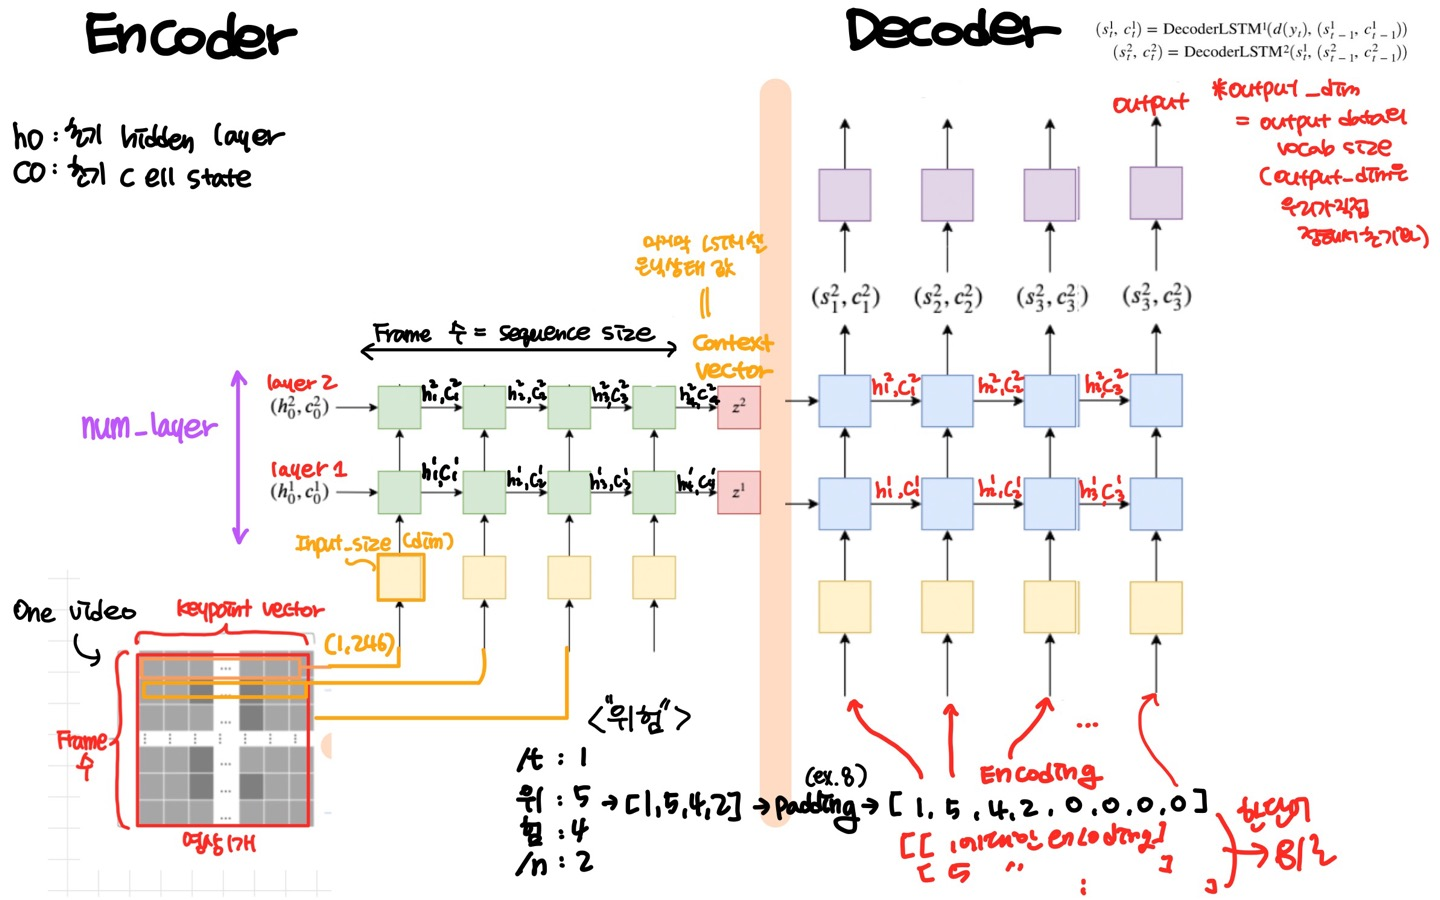

In [4]:
!pip3 install torch==1.2.0
!pip3 install torchvision==0.4.0

     |████████████████████████████████| 748.9 MB 597 bytes/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.


     |████████████████████████████████| 8.8 MB 4.7 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


In [1]:
import os
import numpy as np
import json
import pandas as pd
import torch.nn.functional as F
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import random

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

# Device Settings
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device : ', device)

device :  cuda


In [3]:
print("Torch version:{}".format(torch.__version__))
print("Torchvision version:{}".format(torchvision.__version__))

Torch version:1.2.0
Torchvision version:0.4.0


# Data Load & Preprocessing

Alphapose Keypoint Data Load

In [4]:
cd '/content/drive/MyDrive/BOAZ_수어프로젝트/Data/pickle'

/content/drive/MyDrive/BOAZ_수어프로젝트/Data/pickle


In [5]:
ls

30593_32029_X.pickle  X_test.pickle  X_train.pickle


In [6]:
import gzip
import pickle

In [7]:
with gzip.open('X_train.pickle','rb') as f:
  X_train = pickle.load(f)

In [8]:
X_train.shape # (비디오 개수, frame 개수, keypoint 개수)

(7129, 376, 246)

In [9]:
X_data = X_train

Target Word Data Load

In [10]:
import pandas as pd

target = pd.read_csv('/content/drive/MyDrive/BOAZ_수어프로젝트/Data/train_target.excel')

In [13]:
target1 = target[(target['num'] <= 35620) & (target['num'] >= 30593)]
target2 = target[(target['num'] <= 42131) & (target['num'] >= 40028)]
target = target1.append(target2)
drop_idx = target.loc[(target['num']== 41098) | (target['num'] == 41106) | (target['num'] == 41108)].index
target.drop(drop_idx,axis=0,inplace=True)

In [15]:
target.shape

(7129, 2)

In [18]:
target['target']

20112                             0
20113                             1
20114                             2
20115                             3
20116                             4
                    ...            
31646    술 취한 사람이 방망이로 사람들을 때리고 있어요
31647                     집에 불이 났어요
31648              집에 도둑(강도)이 들어왔어요
31649             어떤 사람이 교통사고를 당했어요
31650           식사를 하다가 목에 음식이 걸렸어요
Name: target, Length: 7129, dtype: object

In [20]:
# for i in range(len(target)):
#   target['target'][i]=str(target['target'][i])

target= target['target']
target
# 단어 target에서 기호같은거 제거해주는 등의 전처리 필요할 것으로 생각됨 !!!!

20112                             0
20113                             1
20114                             2
20115                             3
20116                             4
                    ...            
31646    술 취한 사람이 방망이로 사람들을 때리고 있어요
31647                     집에 불이 났어요
31648              집에 도둑(강도)이 들어왔어요
31649             어떤 사람이 교통사고를 당했어요
31650           식사를 하다가 목에 음식이 걸렸어요
Name: target, Length: 7129, dtype: object

In [21]:
# 부가적으로 필요없는 문자들 제거해주기
target=target.map(lambda x: re.sub('[(-,)=.#/?:$}]','', x))

'-' 같은 기호 띄어쓰기로 대체

In [22]:
# 시작 구분기호로 \t를 끝 구분기호로 \n을 추가해줌
target = target.apply(lambda x : 's '+ x + ' f')

Target data preprocessing

In [23]:
# 글자 집합 구축
tar_vocab = set()
for line in target:
  tar_vocab.add(line)

In [24]:
temp = []
for line in target:
  temp.append(line)

In [25]:
temp[-1:]

['s 식사를 하다가 목에 음식이 걸렸어요 f']

In [26]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
from nltk.tokenize import word_tokenize

vocab = {}
preprocessed_sentences = []

for sentence in temp:
    # 단어 토큰화
    tokenized_sentence = word_tokenize(sentence)
    result = []

    for word in tokenized_sentence:
      result.append(word)
      if word not in vocab:
        vocab[word] = 0
      vocab[word] += 1
    preprocessed_sentences.append(result) 
print(preprocessed_sentences)

[['s', '0', 'f'], ['s', '1', 'f'], ['s', '2', 'f'], ['s', '3', 'f'], ['s', '4', 'f'], ['s', '5', 'f'], ['s', '6', 'f'], ['s', '7', 'f'], ['s', '8', 'f'], ['s', '9', 'f'], ['s', '10', 'f'], ['s', '11', 'f'], ['s', '12', 'f'], ['s', '13', 'f'], ['s', '14', 'f'], ['s', '15', 'f'], ['s', '16', 'f'], ['s', '17', 'f'], ['s', '18', 'f'], ['s', '19', 'f'], ['s', '20', 'f'], ['s', '21', 'f'], ['s', '22', 'f'], ['s', '23', 'f'], ['s', '24', 'f'], ['s', '25', 'f'], ['s', '26', 'f'], ['s', '27', 'f'], ['s', '28', 'f'], ['s', '29', 'f'], ['s', '30', 'f'], ['s', '31', 'f'], ['s', '32', 'f'], ['s', '33', 'f'], ['s', '34', 'f'], ['s', '35', 'f'], ['s', '36', 'f'], ['s', '37', 'f'], ['s', '38', 'f'], ['s', '39', 'f'], ['s', '40', 'f'], ['s', '41', 'f'], ['s', '42', 'f'], ['s', '43', 'f'], ['s', '44', 'f'], ['s', '45', 'f'], ['s', '46', 'f'], ['s', '47', 'f'], ['s', '48', 'f'], ['s', '49', 'f'], ['s', '50', 'f'], ['s', '51', 'f'], ['s', '52', 'f'], ['s', '53', 'f'], ['s', '54', 'f'], ['s', '55', 'f'], [

In [28]:
print('단어 집합 :',vocab) # 단어와 빈도수 집합

단어 집합 : {'s': 7129, '0': 12, 'f': 7129, '1': 12, '2': 12, '3': 12, '4': 12, '5': 12, '6': 12, '7': 12, '8': 12, '9': 12, '10': 12, '11': 12, '12': 12, '13': 12, '14': 12, '15': 12, '16': 12, '17': 12, '18': 12, '19': 12, '20': 12, '21': 12, '22': 12, '23': 12, '24': 12, '25': 12, '26': 12, '27': 12, '28': 12, '29': 12, '30': 12, '31': 12, '32': 12, '33': 12, '34': 12, '35': 12, '36': 12, '37': 12, '38': 12, '39': 12, '40': 12, '41': 12, '42': 12, '43': 12, '44': 12, '45': 12, '46': 12, '47': 12, '48': 12, '49': 12, '50': 12, '51': 12, '52': 12, '53': 12, '54': 12, '55': 12, '56': 12, '57': 12, '58': 12, '59': 12, '60': 12, '61': 12, '62': 12, '63': 12, '64': 12, '65': 12, '66': 12, '67': 12, '68': 12, '69': 12, '70': 12, '71': 12, '72': 12, '73': 12, '74': 12, '75': 12, '76': 12, '77': 12, '78': 12, '79': 12, '80': 12, '81': 12, '82': 12, '83': 12, '84': 12, '85': 12, '86': 12, '87': 12, '88': 12, '89': 12, '90': 12, '91': 12, '92': 12, '93': 12, '94': 12, '95': 12, '96': 12, '97': 12,

In [33]:
vocab_sorted = sorted(vocab.items(), key = lambda x:x[1], reverse = True)
print(vocab_sorted)

[('s', 7129), ('f', 7129), ('사람이', 380), ('있어요', 259), ('어떤', 240), ('같아요', 200), ('났어요', 161), ('불이', 141), ('것', 140), ('갑자기', 120), ('집에', 102), ('친구가', 80), ('아이가', 80), ('당했어요', 61), ('몸이', 60), ('끼었어요', 60), ('삼켰어요', 60), ('아기가', 60), ('저를', 60), ('있는', 60), ('안', 60), ('갇혔어요', 60), ('많이', 60), ('모르는', 60), ('불러주세요', 60), ('밖에', 60), ('감전', 52), ('하다가', 41), ('집이', 40), ('멈췄어요', 40), ('해안가에', 40), ('나타났어요', 40), ('폭탄이', 40), ('터졌어요', 40), ('쓰러지셨어요', 40), ('쓰러졌어요', 40), ('장난감을', 40), ('음식을', 40), ('숨을', 40), ('나고', 40), ('피를', 40), ('흘리고', 40), ('못', 40), ('쏘였어요', 40), ('가스가', 40), ('새고', 40), ('해요', 40), ('도와주세요', 40), ('아이를', 40), ('심해요', 40), ('아파서', 40), ('빨리', 40), ('방에', 40), ('수', 40), ('없어요', 40), ('칼에', 40), ('강아지가', 39), ('산에서', 39), ('물렸어요', 39), ('옆집', 36), ('119', 32), ('결박', 32), ('무릎', 32), ('병원', 32), ('서대문구', 32), ('집', 32), ('아저씨', 24), ('할아버지', 24), ('유치원', 24), ('도둑강도이', 21), ('들어왔어요', 21), ('교통사고를', 21), ('식사를', 21), ('목에', 21), ('음식이', 21), ('걸렸어요', 21), ('홍수

In [35]:
word_to_index = {}

for i, (word, frequency) in enumerate(vocab_sorted):
  word_to_index[word] = i

print(word_to_index)

{'s': 0, 'f': 1, '사람이': 2, '있어요': 3, '어떤': 4, '같아요': 5, '났어요': 6, '불이': 7, '것': 8, '갑자기': 9, '집에': 10, '친구가': 11, '아이가': 12, '당했어요': 13, '몸이': 14, '끼었어요': 15, '삼켰어요': 16, '아기가': 17, '저를': 18, '있는': 19, '안': 20, '갇혔어요': 21, '많이': 22, '모르는': 23, '불러주세요': 24, '밖에': 25, '감전': 26, '하다가': 27, '집이': 28, '멈췄어요': 29, '해안가에': 30, '나타났어요': 31, '폭탄이': 32, '터졌어요': 33, '쓰러지셨어요': 34, '쓰러졌어요': 35, '장난감을': 36, '음식을': 37, '숨을': 38, '나고': 39, '피를': 40, '흘리고': 41, '못': 42, '쏘였어요': 43, '가스가': 44, '새고': 45, '해요': 46, '도와주세요': 47, '아이를': 48, '심해요': 49, '아파서': 50, '빨리': 51, '방에': 52, '수': 53, '없어요': 54, '칼에': 55, '강아지가': 56, '산에서': 57, '물렸어요': 58, '옆집': 59, '119': 60, '결박': 61, '무릎': 62, '병원': 63, '서대문구': 64, '집': 65, '아저씨': 66, '할아버지': 67, '유치원': 68, '도둑강도이': 69, '들어왔어요': 70, '교통사고를': 71, '식사를': 72, '목에': 73, '음식이': 74, '걸렸어요': 75, '홍수가': 76, '나서': 77, '물에': 78, '잠기고': 79, '엘리베이터가': 80, '중간에': 81, '자살을': 82, '시도하고': 83, '바다에': 84, '빠졌어요': 85, '상어가': 86, '해파리가': 87, '주변': 88, '구조물이': 89, '무너져서': 90, '몸을': 91,

In [36]:
len(word)

2

In [37]:
# 각 글자에 index 부여

encoded_sentences = []
for sentence in preprocessed_sentences:
    encoded_sentence = []
    for word in sentence:
      encoded_sentence.append(word_to_index[word])
    encoded_sentences.append(encoded_sentence)
print(encoded_sentences)

[[0, 269, 1], [0, 270, 1], [0, 271, 1], [0, 272, 1], [0, 273, 1], [0, 274, 1], [0, 275, 1], [0, 276, 1], [0, 277, 1], [0, 278, 1], [0, 279, 1], [0, 280, 1], [0, 281, 1], [0, 282, 1], [0, 283, 1], [0, 284, 1], [0, 285, 1], [0, 286, 1], [0, 287, 1], [0, 288, 1], [0, 289, 1], [0, 290, 1], [0, 291, 1], [0, 292, 1], [0, 293, 1], [0, 294, 1], [0, 295, 1], [0, 296, 1], [0, 297, 1], [0, 298, 1], [0, 299, 1], [0, 300, 1], [0, 301, 1], [0, 302, 1], [0, 303, 1], [0, 304, 1], [0, 305, 1], [0, 306, 1], [0, 307, 1], [0, 308, 1], [0, 309, 1], [0, 310, 1], [0, 311, 1], [0, 312, 1], [0, 313, 1], [0, 314, 1], [0, 315, 1], [0, 316, 1], [0, 317, 1], [0, 318, 1], [0, 319, 1], [0, 320, 1], [0, 321, 1], [0, 322, 1], [0, 323, 1], [0, 324, 1], [0, 325, 1], [0, 326, 1], [0, 327, 1], [0, 328, 1], [0, 329, 1], [0, 330, 1], [0, 331, 1], [0, 332, 1], [0, 333, 1], [0, 334, 1], [0, 335, 1], [0, 336, 1], [0, 337, 1], [0, 338, 1], [0, 339, 1], [0, 340, 1], [0, 341, 1], [0, 342, 1], [0, 343, 1], [0, 344, 1], [0, 345, 1]

In [38]:
max_tar_len = max([len(line) for line in temp])
print(max_tar_len)

40


In [39]:
decoder_input = pad_sequences(encoded_sentences, maxlen=max_tar_len, padding='post')
decoder_input.shape

(7129, 40)

In [40]:
X_train= torch.tensor(X_train)
decoder_input = torch.LongTensor(decoder_input)

In [41]:
decoder_Input= decoder_input

In [ ]:
X_train = X_data[:6000]
X_valid = X_data[6000:7000]
X_test = X_data[7000:]

decoder_input = decoder_Input[:6000]
decoder_input_valid = decoder_Input[6000:7000]
decoder_input_test = decoder_Input[7000:]

In [43]:
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
X_test = torch.tensor(X_test)

decoder_input = torch.tensor(decoder_input, dtype=torch.long)
decoder_input_valid = torch.tensor(decoder_input_valid, dtype=torch.long)
decoer_input_test = torch.tensor(decoder_input_test, dtype=torch.long)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Dataloader

In [44]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, decoder_input)
valid_dataset = TensorDataset(X_valid, decoder_input_valid)

In [75]:
train_dataloader = DataLoader(train_dataset,batch_size= 32,shuffle= True) # create your dataloader
valid_dataloader = DataLoader(valid_dataset,batch_size= 32,shuffle= True)# create your dataloader

In [76]:
for i, (keypoints, labels) in enumerate(train_dataloader):
    print(i)
    print(keypoints.shape)
    print(labels.shape)
    if i ==2:
      break

0
torch.Size([32, 376, 246])
torch.Size([32, 40])
1
torch.Size([32, 376, 246])
torch.Size([32, 40])
2
torch.Size([32, 376, 246])
torch.Size([32, 40])


따라서 input data가 (batch_size, frame수, keypoint개수)로 변경됨
target data는 (batch_size, embedding_matrix(12개로 padding한 단어를 128차원으로 임베딩)

# Modeling seq2seq

Encoder

In [77]:
# Encoder 정의하기 

class Encoder(nn.Module):
    def __init__(self, input_size, hid_dim, n_layers):
        super().__init__() 
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        # batch_first = True
        self.gru = nn.GRU(input_size, hid_dim, n_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hid_dim*2, hid_dim)
        # input_size = keypoint 개수

    def forward(self, x): 
        # input x : (BATCH, LENGTH, INPUT_SIZE)임  (다양한 length를 다룰 수 있습니다.).
        # 최초의 hidden state와 cell state를 초기화
        
        # x = ([16, 81, 246])
        # h0 = (2, batch, 512)
        h0 = torch.zeros(self.n_layers*2, x.size(0), self.hid_dim).to(device).float()

        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layer * n directions, batch size, hid dim]
        # print(h0.shape) # torch.Size([2, 2, 512])
        # LSTM 순전파
        out, hidden = self.gru(x, h0)
        #print(hidden.shape)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
    
        # print(out.shape) # torch.Size([2, 227, 1024]) = batch, frame, hidden*2

        # output : (BATCH_SIZE, SEQ_LENGTH, HIDDEN_SIZE) tensors. 
        return out, hidden

Attention

In [78]:
class Attention(nn.Module):
    def __init__(self, hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((hid_dim * 2) + hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        # hidden = (2, batch, hid_dim) 
        # output =  batch, frame, hidden*2

        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        # print(hidden.shape) # torch.Size([2, 512])


        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        # print(hidden.shape)
        # print(encoder_outputs.shape)

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

Decoder

In [79]:
class Decoder(nn.Module):
    def __init__(self, output_dim,  emb_dim, hid_dim, n_layers, attention,dropout):
        super().__init__() 

        # output_dim = len(TRG.vocab) softmax로 총 단어 집합 중 어떤 단어인지 선택

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.attention = attention
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.gru = nn.GRU(hid_dim*2+emb_dim, hid_dim)
        self.fc_out = nn.Linear((hid_dim*2)+hid_dim+emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        

    def forward(self, input, hidden, encoder_outputs): 

        # LSTM 순전파
        # input = [16]
        input = input.unsqueeze(0)  # 1,16
        embedded = self.dropout(self.embedding(input)) # 1, 16, 128

        attention = self.attention(hidden, encoder_outputs)
        attention = attention.unsqueeze(1)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]

        weighted = torch.bmm(attention, encoder_outputs)
        # print('weighted.shape :', weighted.shape) # weighted.shape : torch.Size([2, 1, 1024])
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        # print('rnn_input shape: ' , rnn_input.shape) # rnn_input shape:  torch.Size([1, 2, 1152])
        # print('hidden.shape: ', hidden.shape) # hidden.shape:  torch.Size([2, 512])


        out1, hidden = self.gru(rnn_input, hidden.unsqueeze(0)) # # hidden.shape:  torch.Size([1, 2, 512])


        assert (out1 == hidden).all()
        
        embedded = embedded.squeeze(0)
        out1 = out1.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((out1, weighted, embedded), dim = 1))
 

        # 마지막 time step(sequence length)의 hidden state를 사용해 Class들의 logit을 반환합니다(hid_dim -> num_classes). 
        #out1 = self.fc(out1[:, -1, :])
        
        return prediction,hidden.squeeze(0)

seq2seq

In [80]:
import random
class Seq2Seq(nn.Module):

    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.8):
        
    
        batch_size = trg.shape[0] # 16 batch_size
        trg_len = trg.shape[1] #12 padding
        trg_vocab_size = self.decoder.output_dim

        # output을 저장할 tensor를 만들기.(처음에는 전부 0으로)
        outputs = torch.zeros(trg_len, batch_size,trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
        # outputs = (12(padding), 16(batch), 단어사전의 총 단어개수)
        # src문장을 encoder에 넣은 후 hidden, cell값을 구합니다.

        
        
        # decoder에 입력할 첫번째 input입니다.
        # 첫번째 input은 모두 <sos> token입니다.
        # trg[0,:].shape = BATCH_SIZE 

        # 첫번째인풋은 vocab 모음 중에서 /t를 인코딩한 부분 !!
        input = trg[:,0]

        '''한번에 batch_size만큼의 token들을 독립적으로 계산 -> 즉 frame개수 만큼 Batch 설정??
        즉, 총 trg_len번의 for문이 돌아가며 이 for문이 다 돌아가야지만 하나의 문장이(지금은 단어가) decoding됨
        또한, 1번의 for문당 128개의 문장의 각 token들이 다같이 decoding되는 것'''
        for t in range(1, trg_len): # range(1, 12) -> 12는 단어 하나의 길이를 padding

            #trg_len = 12
            # input token embedding과 이전 hidde state를 decoder에 입력합니다.
            # 새로운 hidde states와 예측 output값이 출력됩니다.

            output, hidden = self.decoder(input, hidden, encoder_outputs)
            #이때 output은 final_state = out1[:,-1,:], prediction = self.fc_out(final_state) 
            #output = [batch_size, output dim] prediction 은?:  torch.Size([1, 341])
            # 각각의 출력값을 outputs tensor에 저장합니다.
            outputs[t] = output
            # outputs = (12(padding), 16(batch), 단어사전의 총 단어개수)
            
            teacher_force = random.random() < teacher_forcing_ratio
      
            # top1 = [batch size]
            top1 = output.argmax(1)

            # teacher forcing기법을 사용한다면, 다음 input으로 target을 입력하고
            # 아니라면 이전 state의 예측된 출력값을 다음 input으로 사용합니다.

            input = trg[:,t] if teacher_force else top1

        return outputs

Parameter & Optimizer

In [81]:
input_size = 246 # keypoint vector 길이
HID_DIM = 512
OUTPUT_DIM = len(vocab)+1
N_LAYERS = 2
DEC_DROPOUT = 0.5
emb_dim = 128


enc = Encoder(input_size, HID_DIM, N_LAYERS)
att = Attention(HID_DIM)
dec = Decoder(OUTPUT_DIM, emb_dim, HID_DIM, N_LAYERS, att, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [82]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (gru): GRU(246, 512, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(677, 128)
    (gru): GRU(1152, 512)
    (fc_out): Linear(in_features=1664, out_features=677, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [83]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,144,549 trainable parameters


In [84]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

## Train and Validation

In [85]:
def train(model, train_dataloader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
   
    for i, (input, target) in enumerate(train_dataloader):

        src = input
        trg = target

        if torch.cuda.is_available():
          model.cuda()
          src = src.cuda().float()
          trg = trg.cuda()
       
        # src = [16, 81, 246] batch, frame수, keypoint수
        # trg(trg)= [16, 12] = batch, trg_len

        optimizer.zero_grad()        
        
        output = model(src, trg)
        #trg = [trg len, batch size] [16,12]
        #output = [trg len, batch size, output dim]
        
        output = output[1:].view(-1, OUTPUT_DIM)
        trg = torch.transpose(trg,0,1)
        trg = trg[1:].contiguous().view(-1)
              
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(train_dataloader)

In [86]:
def evaluate(model, valid_dataloader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
   
      for i,(input, target) in enumerate(valid_dataloader): # valid_dataloader 정의하기
          src = input
          trg = target

          if torch.cuda.is_available():
            model.cuda()
            src = src.cuda().float()
            trg = trg.cuda()

          output = model(src, trg, 0)
          #trg = [trg len, batch size] [16,12]
          #output = [trg len, batch size, output dim]
          
          output = output[1:].view(-1, OUTPUT_DIM)
          trg = torch.transpose(trg,0,1)
          trg = trg[1:].contiguous().view(-1)
                
          #trg = [(trg len - 1) * batch size]
          #output = [(trg len - 1) * batch size, output dim]
          loss = criterion(output, trg)
          
          epoch_loss += loss.item()
          
      return epoch_loss / len(valid_dataloader)

In [105]:
# trg_indexes = [word_to_index['s']]
# a = torch.LongTensor([trg_indexes[-1]]).to(device)
# a

tensor([0], device='cuda:0')

In [108]:
def translate_SL(src, word_to_index, model, device, max_len = 81):
  '''
  src: 번역하고자 하는 keypoint
  word_to_index: korean index 뭉치
  '''

  model.eval()

  # sign_language = "<sos>" + sign_language + "<eos>"
  # print(f"sign language: {sign_language}")
  # 인덱스 파트 (변수명: src_tensor)

  with torch.no_grad():

    encoder_outputs, hidden = model.encoder(src)
  
  trg_indexes = [word_to_index['s']] # [0]
  end_index = word_to_index['f']
  
  for i in range(max_len): #max_len = 81
    # trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
    trg_tensor = torch.tensor([trg_indexes[-1]],dtype=torch.long).to(device) # tensor([0])

    with torch.no_grad():
        output, hidden= model.decoder(trg_tensor, hidden, encoder_outputs)

    pred_token = output.argmax(1).item()

    if pred_token == end_index:
      break
      
    trg_indexes.append(pred_token) # 출력 문장에 더하기
    # # <eos>를 만나는 순간 끝
    # 각 출력 단어 인덱스를 실제 단어로 변환
    # trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    # trg_tokens = [word_to_index[i] for i in trg_indexes]
  trg_tokens = [list(word_to_index)[i] for i in trg_indexes]
    # trg_tokens = [key for key, value in word_to_index.items() if value == i]


    # 첫 번째 <sos>는 제외하고 출력 문장 반환
  return trg_tokens[1:]

In [102]:
def BLEU_Evaluate(model,dataloader,criterion, word_to_index,OUTPUT_DIM , device, max_len = 81):
    '''
    src: 번역하고자 하는 keypoint
    word_to_index: korean index 뭉치
    '''
    zero_pred = 0
    model.eval()
    epoch_loss = 0
    BLEU = 0
    acc = 0
    cnt = 0
    for _,(input, target) in enumerate(dataloader): 
        
        src = input
        trg = target

        if torch.cuda.is_available():
            model.cuda()
            src = src.cuda().float()

            trg = trg.cuda()
            trg2 = trg

        with torch.no_grad(): # evaluation
            
            # hidden, cell = model.encoder(src)
            output = model(src,trg,0) # evaluate
            output = output[1:].view(-1,OUTPUT_DIM) # evaluate
            trg = torch.transpose(trg,0,1) # evaluate
            trg = trg[1:].contiguous().view(-1) # evaluate

            loss = criterion(output,trg) # evaluate
            epoch_loss += loss.item() # evaluate
        
        for input_data,target in zip(src,trg2):
            input_data = torch.unsqueeze(input_data, 0)
            cnt += 1
            ref = []
            for t in target:
                if t == 1:
                    break
                else:
                    ref.append(list(word_to_index)[t])
            ref = ' '.join(ref)
            
            candidate = ' '.join(translate_SL(input_data, word_to_index, model, device,max_len))
            ref = re.sub('[sf]','',ref)
            ref = ref.strip()
            print(candidate)
            print(ref)
            if len(candidate.split()) == 0:
                zero_pred += 1
            else:
                BLEU += bleu.sentence_bleu([ref.split()], candidate.split(),weights = [1,0,0,0])
                acc += sum(x == y for x, y in zip(ref.split(), candidate.split())) / len(candidate.split())
            if cnt == zero_pred:
                BLEU , acc = 0
            else:
                BLEU = BLEU / (cnt - zero_pred)
                acc = acc/(cnt - zero_pred)
    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return epoch_loss / len(dataloader), BLEU, acc

In [89]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [90]:
from tqdm.notebook import tqdm
import time

import gc
gc.collect()
torch.cuda.empty_cache()

In [101]:
import nltk.translate.bleu_score as bleu
import math

In [ ]:
best_valid_loss = float('inf')
BLEU_ls = []
train_loss_ls = []
N_EPOCHS = 30
val_loss_ls = []
max_len = 81
acc_ls = []
epoch_ls = [i for i in range(N_EPOCHS)]
model_save_path = './'
save_model_name = 'model1.pt'
CLIP = 1
    
for epoch in tqdm(range(N_EPOCHS)):
    start_time = time.time()

    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    valid_loss, BLEU,acc = BLEU_Evaluate(model,valid_dataloader,criterion, word_to_index, OUTPUT_DIM, device, max_len=81)

    train_loss_ls.append(train_loss)
    val_loss_ls.append(valid_loss)
    BLEU_ls.append(BLEU)
    acc_ls.append(acc)
    # valid_loss = evaluate(model, val_dataloader, OUTPUT_DIM,criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'{model_save_path}{save_model_name}')
    
    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val Loss: {valid_loss:.3f} | Val PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Val BLEU : {BLEU : .3f} | Val Accuracy : {acc : .3f}')

  0%|          | 0/30 [00:00<?, ?it/s]

알려주세요
유리가 깨져서 발을 다쳤어요
진통제
어떤 사람이 집단폭력을 당하고 있어요
산에서 야생동물을 만났어요 저를 공격할 것 같아요
산에서 야생동물을 만났어요 저를 공격할 것 같아요
아내가 쓰러졌어요
아내가 쓰러졌어요
끓는물
음식을 하다가 손가락을 칼에 베였어요
성동구
집에 전기가 나갔어요
말벌에게 쏘였어요
사람이 갑자기 쓰러졌어요


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


식사를 하다가 목에 음식이 걸렸어요
식사를 하다가 목에 음식이 걸렸어요
산에서 뱀에게 물렸어요
친구가 숨을 안 쉬는 것 같아요
어떤 사람이 교통사고를 당했어요
어떤 사람이 교통사고를 당했어요
깔리다
사람이 무거운 물건에 깔렸어요
집에 불이 났어요
윗집에 불이 났어요
진통제
어떤 사람이 자살을 시도하고 있어요
어떤 사람이 자살을 시도하고 있어요
어떤 사람한테 납치당했어요


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


근처에 있는 건물이 붕괴되고 있어요
근처에 있는 건물이 붕괴되고 있어요
어떤 사람이 자살을 시도하고 있어요
어떤 사람이 칼에 찔려서 피를 많이 흘리고 있어요
진통제
어떤 사람이 교통사고를 당했어요
아기를 낳을것 같아요
아기를 낳을것 같아요
운동장
아기가 숨을 안 쉬어요
아이가 방에 갇혔어요
터널이 무너져 갇혔어요
보내주세요구급차
엄마가 신장병에 있는데 쓰러지셨어요
진통제
어떤 사람이 자살을 시도하고 있어요
해안가에 상어가 나타났어요
어떤 사람이 저를 죽이려고 해요
결박 방에 갇혔어요
아이가 방에 갇혔어요
보내주세요구급차
엄마가 신장병에 있는데 쓰러지셨어요
해안가에 상어가 나타났어요
해안가에 상어가 나타났어요
아기를 낳을것 같아요
아기를 낳을것 같아요
집에 불이 났어요
윗집에 불이 났어요
말벌에게 쏘였어요
아이가 말벌에 쏘여서 기절했어요
왼쪽-눈
문에 몸이 끼었어요
성북구
집이 흔들려요
말벌에게 쏘였어요
어지러워서 서있을 수 없어요
산에서 뱀에게 물렸어요
아랫집에 불이 났어요
독극물
아파서 못 참을것 같아요
말벌에게 쏘였어요
말벌에게 쏘였어요
골절
친구가 감전 사고를 당했어요
진통제
산에서 뱀에게 물렸어요
진통제
동생이 문틈에 손이 끼었어요
식사를 하다가 목에 음식이 걸렸어요
식사를 하다가 목에 음식이 걸렸어요
허리가 연기가 나요 s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s
쫓아오는 것 같아요
성북구
옆집에 불이 났어요
터널이 무너져 갇혔어요
터널이 무너져 갇혔어요
성동구
문에 몸이 끼었어요
산에서 입었어요
화상을 입었어요
아이를 모르는 사람이 데려갔어요
아이를 모르는 사람이 데려갔어요
산에서 뱀에게 물렸어요
지하철 역 안에서 화재가 발생했어요
보내주세요구급차
세브란스 병원 진료 예약을 해주세요
보내주세요구급차
이상한 사람이 저를 

## Test code

In [ ]:
# example_idx = 10

src = X_test[0].reshape(-1, 227, 246).cuda().float() # 인덱스 번호 넣기
trg = target[900] # 인덱스 번호 넣기

# src = vars(test_dataset.examples[example_idx])['src']
# trg = vars(test_dataset.examples[example_idx])['trg']

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')
print("모델 출력 결과:", " ".join(translate_SL(src, word_to_index, model, device)))